# STA 141B Lecture 16

The class website is <https://github.com/2019-winter-ucdavis-sta141b/notes>

### Announcements


### Topics

* Presentation skills
* A few more SQL examples
* Intro to interactive visualizations

### Datasets

* The [Stock Market Database](http://anson.ucdavis.edu/~clarkf/sql/stocks.sqlite)
* The Gapminder Dataset (included in this repository)

### References

* SQL
    + [SQLZoo Tutorial](http://sqlzoo.net/wiki/SQL_Tutorial)
    + [Tutorial Point's SQL Tutorial](http://www.tutorialspoint.com/sql/)
    + [SQL Cheatsheet](http://anson.ucdavis.edu/~clarkf/sql/sql_cheatsheet.pdf)
* [The Best Stats You've Ever Seen (Gapminder)](https://www.youtube.com/watch?v=hVimVzgtD6w&t=338s)
* JavaScript (for web visualizations)
    + [Learn X in Y Minutes, X = JavaScript][js-intro] -- a brief intro
    + [MDN JavaScript Guide][js-guide] -- a detailed guide
    + [MDN Learning Materials][web-intro] -- more information about web development

[PDSH]: https://jakevdp.github.io/PythonDataScienceHandbook/
[ProGit]: https://git-scm.com/book/
[nlpp]: https://www.nltk.org/book/
[atap]: https://search.library.ucdavis.edu/primo-explore/fulldisplay?docid=01UCD_ALMA51320822340003126&context=L&vid=01UCD_V1&search_scope=everything_scope&tab=default_tab&lang=en_US
[js-intro]: https://learnxinyminutes.com/docs/javascript/
[js-guide]: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Guide
[web-intro]: https://developer.mozilla.org/en-US/docs/Learn

In [1]:
# NEW PACKAGES
import bokeh.io       # conda install bokeh
import imageio        # conda install -c conda-forge imageio
import folium         # conda install -c conda-forge folium
# For feather files:  # conda install -c conda-forge pyarrow

# DATA SCIENCE TOOLKIT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

import sqlite3 as sql

# Presentation Skills

See the [presentation description](https://github.com/2019-winter-ucdavis-sta141b/notes/blob/master/presentation.md).

# SQL Examples

The questions below use the [stock market database](http://anson.ucdavis.edu/~clarkf/sql/stocks.sqlite). You can find additional practice problems [here](http://anson.ucdavis.edu/~clarkf/sql/).


1. Write a query that produces a table with columns for state,  SIC code,  SIC description, and count of companies located in that state with that SIC code.

In [3]:
db = sql.connect("../data/stocks.sqlite")

In [4]:
pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,company_name,company_name,2,"CREATE TABLE ""company_name"" (\n ""ticker"" TEXT..."
1,table,financial_ratios,financial_ratios,16,"CREATE TABLE ""financial_ratios"" (\n ""ticker"" ..."
2,table,company_info,company_info,54,"CREATE TABLE ""company_info"" (\n ""ticker"" TEXT..."
3,table,daily_share_prices,daily_share_prices,111,"CREATE TABLE ""daily_share_prices"" (\n ""date"" ..."
4,table,sic,sic,39180,"CREATE TABLE ""sic"" (\n ""Division"" TEXT,\n ""M..."
5,table,state_populations,state_populations,39285,"CREATE TABLE ""state_populations"" (\n ""state"" ..."
6,table,company_locations,company_locations,39237,"CREATE TABLE ""company_locations"" (\n ""rank201..."
7,table,fang_info,fang_info,39240,"CREATE TABLE fang_info(\n ticker TEXT,\n com..."
8,table,fang_prices,fang_prices,39241,"CREATE TABLE fang_prices(\n ticker TEXT,\n d..."
9,table,fang_locations,fang_locations,39242,"CREATE TABLE fang_locations(\n ticker TEXT,\n..."


In [5]:
pd.read_sql("SELECT * FROM company_locations LIMIT 3", db)

,rank2015,rank2014,trend,company,street,city,state,zip,xcoord,ycoord,ticker
0,1,1,Neutral,Walmart,702 S.W. Eighth St.,Bentonville,Arkansas,72716,-94.217629,36.365378,WMT
1,2,2,Neutral,Exxon Mobil,5959 Las Colinas Blvd.,Irving,Texas,75039,-96.949909,32.890006,XOM
2,3,3,Neutral,Chevron,6001 Bollinger Canyon Rd.,San Ramon,California,94583,-121.958096,37.758251,CVX


In [6]:
pd.read_sql("SELECT * FROM sic LIMIT 3", db)

,Division,Major.Group,Industry.Group,SIC,Description
0,A,1,11,111,Wheat
1,A,1,11,112,Rice
2,A,1,11,115,Corn


In [7]:
pd.read_sql("SELECT * FROM company_info LIMIT 3", db)

,ticker,company_name,industry,sector,sic_code,web_page,asset,revenue,net_income,earning_per_share
0,WMT,WAL MART STORES INC,Food Retail & Distribution,Consumer Non-Cyclicals,5331.0,www.walmartstores.com,1.988250e+11,4.858730e+11,1.364300e+10,4.38
1,XOM,EXXON MOBIL CORP,Oil & Gas Refining and Marketing,Energy,2911.0,http://www.exxonmobil.com/,3.303140e+11,2.186080e+11,7.840000e+09,1.88
2,MCK,MCKESSON CORP,Drug Retailers,Consumer Non-Cyclicals,5122.0,www.mckesson.com,6.096900e+10,1.985330e+11,5.070000e+09,22.73


In [13]:
pd.read_sql("""
    SELECT a.state, a.sic_code, b.description, COUNT(*) AS total FROM
    (
        SELECT l.ticker, l.state, l.company, r.company_name, r.sic_code FROM
            company_locations AS l
        INNER JOIN
            company_info AS r
        ON l.ticker = r.ticker
    ) AS a
    LEFT JOIN
        sic AS b
    ON a.sic_code = b.sic
    GROUP BY state, sic_code
    ORDER BY total DESC
""", db)

,state,sic_code,Description,total
0,Texas,1311.0,Crude Petroleum and Natural Gas,4
1,Texas,2911.0,Petroleum Refining,4
2,California,7372.0,Prepackaged Software,3
3,New York,6211.0,"Security Brokers, Dealers, and Flotation Compa...",3
4,California,2836.0,"Biological Products, Except Diagnostic Substances",2
5,California,3572.0,Computer Storage Devices,2
6,California,3674.0,Semiconductors and Related Devices,2
7,California,5651.0,Family Clothing Stores,2
8,California,7389.0,"Business Services, Not Elsewhere Classified",2
9,Connecticut,6324.0,Hospital and Medical Service Plans,2


2. Focusing only on 2014 and the daily share prices table, find the names of the companies which had any closing price that exceeded the average closing price of AAPL in 2014.

In [20]:
# First get the average closing price of AAPL in 2014.

pd.read_sql("""
    SELECT AVG(close) FROM daily_share_prices
    WHERE ticker = 'AAPL'
    AND date BETWEEN '2014-01-01' AND '2014-12-31'
""", db)

,AVG(close)
0,92.264531


In [22]:
# Now we need to get the distinct tickers from daily_share_prices where a 2014 close price was greater than the AAPL average.
# We can use the first query (above) as a subquery to get the AAPL average.

pd.read_sql("""
    SELECT DISTINCT ticker FROM daily_share_prices
    WHERE date BETWEEN '2014-01-01' AND '2014-12-31'
    AND close > (
        SELECT AVG(close) FROM daily_share_prices
        WHERE ticker = 'AAPL'
        AND date BETWEEN '2014-01-01' AND '2014-12-31'
    )
""", db)

,ticker
0,AAPL
1,AAP
2,ABC
3,ADS
4,AGN
5,ALXN
6,AMGN
7,AMG
8,AMP
9,AMT


In [31]:
# Finally, we need to get the company names.
# So we need to join the tickers from the second query (above) with the company_locations table.
# Once again, we'll use a subquery.

pd.read_sql("""
    SELECT l.*, r.company FROM (
        SELECT DISTINCT ticker FROM daily_share_prices
        WHERE date BETWEEN '2014-01-01' AND '2014-12-31'
        AND close > (
            SELECT AVG(close) FROM daily_share_prices
            WHERE ticker = 'AAPL'
            AND date BETWEEN '2014-01-01' AND '2014-12-31'
        )
    ) AS l
    LEFT JOIN
    company_locations AS r
    ON l.ticker = r.ticker
""", db)

,ticker,company
0,AAPL,Apple
1,AAP,Advance Auto Parts
2,ABC,AmerisourceBergen
3,ADS,Alliance Data Systems
4,AGN,Allergan
5,ALXN,None
6,AMGN,Amgen
7,AMG,None
8,AMP,Ameriprise Financial
9,AMT,None


3. Did the Brexit vote affect share prices for commercial banks in the United States? How?

In [19]:
# Brexit happened on June 23, 2016

pd.read_sql("SELECT ticker FROM company_info WHERE industry = 'Banks'", db)

,ticker
0,FNMA
1,JPM
2,BAC
3,WFC
4,C
5,USB
6,PNC
7,BBT
8,STI
9,FITB


In [4]:
df = pd.read_sql("""
    SELECT * FROM daily_share_prices
    WHERE date BETWEEN '2016-06-13' AND '2016-07-13'
    AND ticker IN (
        SELECT ticker FROM company_info WHERE industry = 'Banks'
    )
""", db)

df.head()

,date,open,high,low,close,volume,ticker
0,2016-06-13,13.64,13.9051,13.58,13.60,74851719,BAC
1,2016-06-14,13.56,13.7262,13.17,13.26,85377775,BAC
2,2016-06-15,13.38,13.6600,13.28,13.34,100659070,BAC
3,2016-06-16,13.23,13.3300,13.02,13.31,90151952,BAC
4,2016-06-17,13.38,13.5300,13.28,13.40,89022300,BAC


In [5]:
df["date"] = pd.to_datetime(df["date"])

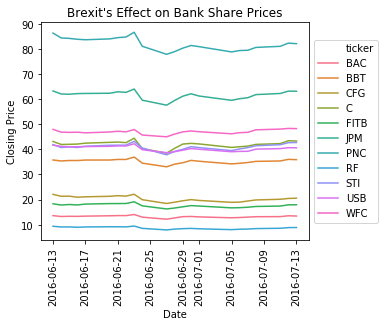

In [18]:
ax = sns.lineplot("date", "close", hue = "ticker", data = df)
    
ax.set_title("Brexit's Effect on Bank Share Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")
for tick in ax.get_xticklabels():
    tick.set_rotation("vertical")
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))

ax

# Intro to Interactive Visualizations

There are a lot of Python packages for visualization:

![Python visualization landscape](img/visualization_landscape.png)
_Image from [Jake VanderPlas](https://speakerdeck.com/jakevdp/pythons-visualization-landscape-pycon-2017). See [here](https://rougier.github.io/python-visualization-landscape/landscape-colors.html) for a version with links to all of the packages!_

When you choose a visualization package, there are three major decisions to make. Consider whether your visualization will:

* Be interactive, animated, or static?
* Display two dimensions, or three?
* Be an image, a video, a web page, or something else?

So far we've made visualizations with packages based on __matplotlib__. These tend to be static 2-dimensional images.

Now we're going to study how to make other kinds of visualizations.

## Animated Visualizations

__matplotlib__ can also make animated videos. The `matplotlib.animation` submodule ([docs](https://matplotlib.org/api/animation_api.html)) provides support for animation.

There are examples online:

* [Drawing animated GIFs with matplotlib](https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/)
* [How to Create Animated Graphs in Python](https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1)
* [Animated histogram](https://matplotlib.org/gallery/animation/animated_histogram.html)

### Flipbook Strategy

There's another simple strategy for making animated visualizations. The strategy is the same as an old-fashioned pen-and-paper flipbook: create lots of still images and flip through them quickly.

A good thing about this strategy is that it works with any package that can make static visualizations. The tradeoff is that you have to write code to create the images -- but usually this isn't too hard.

To use this strategy, you'll need a Python package that can save animated images. Let's look at an example using the __imageio__ package to save a GIF image. We'll use the Gapminder Dataset, which contains statistics for countries from 1800 to 2015. This dataset is based on data from the [Gapminder Project](https://www.gapminder.org/).

In [ ]:
import imageio    # conda install -c conda-forge imageio


def render_frame(year, data):
    """Render a single frame (plot) in an animated visualization.
    
    Adapted from: https://ndres.me/post/matplotlib-animated-gifs-easily/
    """
    # Create a matplotlib figure to plot into.
    fig = plt.figure(figsize = (10, 5))
    
    # -------------------- Visualization Code
    
    # FILL THIS IN
    
    # -------------------- End Visualization Code

    # Draw the figure and then convert it to a Numpy array.
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype = "uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Close the matplotlib figure (we're done with it)
    plt.close()
    return image

In [ ]:
# Save a list of images as a GIF file.
imageio.mimsave("gapminder.gif", plots, fps = 3)